# Advanced interventions

In this example we'll cover

- how to schedule interventions on specific model stages;
- how to write you own interventions.

## Adding an intervention to a specific model stage

We've [already](/feedbax/examples/3_intervening#adding-a-force-field) used [`add_intervenor`][feedbax.intervene.add_intervenor] and [`schedule_intervenor`][feedbax.intervene.schedule_intervenor] to add interventions to models. In doing so, we did not make any mention of the names of any of the model stages. In that case, interventions are added by default to the first stage in the model.

!!! Note ""
    Keep in mind that interventions are always called at the *start* of a stage, before that stage's component. Check the generalized [definition of `SimpleFeedback.__call__`](/feedbax/examples/5_model_stages#simple_feedback_general_def) from the preceding example if you're unsure about exactly how this happens.

Now we'll see an example where it's important that an intervention be applied at a particular stage of a model, which we have to specify.

First, train the model we'll be applying interventions to, and see how it behaves in the absence of interventions.

In [1]:
import jax

from feedbax.xabdeef import point_mass_nn_simple_reaches

seed = 1234
key = jax.random.PRNGKey(seed)
key_init, key_train, key_eval = jax.random.split(key, 3)

context = point_mass_nn_simple_reaches(key=key_init)

task = context.task  # Shorthand, for later

model, train_history = context.train(
    n_batches=1000,
    batch_size=250,
    learning_rate=1e-2,
    log_step=500,
    key=key_train,
)

Training step compiled in 2.51 seconds.
Validation step compiled in 2.06 seconds.


train batch:   0%|          | 0/1000 [00:00<?, ?it/s]


Training iteration: 0
	training loss: 2.39e+01
	validation loss: 5.36e+00

Training iteration: 500
	training loss: 4.01e-03
	validation loss: 7.44e-04

Training iteration: 999
	training loss: 2.68e-03
	validation loss: 5.71e-04

Completed training run on a total of 250,000 trials.


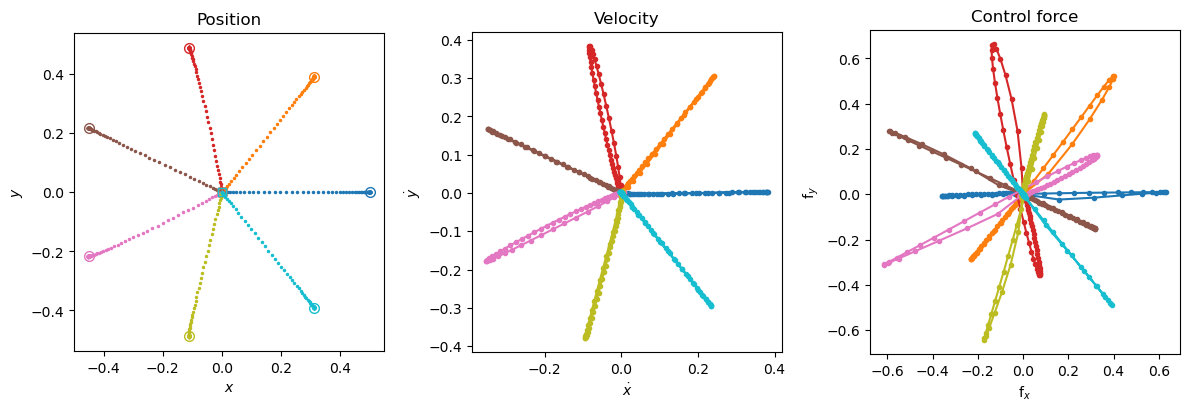

In [2]:
from feedbax.plot import plot_reach_trajectories

states = task.eval(model, key=key_eval)

_ = plot_reach_trajectories(states, trial_specs=task.validation_trials)

### Inspecting staged models 

We're going to intervene on the hidden state of one of the units in the neural network, so let's check out what the network's stages look like.

First, what kind of model is the network? Is it even staged?

In [3]:
model.step.net

SimpleStagedNetwork(
  hidden=GRUCell(
    weight_ih=f32[150,8],
    weight_hh=f32[150,50],
    bias=f32[150],
    bias_n=f32[50],
    input_size=8,
    hidden_size=50,
    use_bias=True
  ),
  hidden_size=50,
  hidden_noise_std=None,
  hidden_nonlinearity=<function identity_func>,
  out_size=2,
  out_nonlinearity=<function identity_func>,
  readout=Linear(
    weight=f32[2,50],
    bias=f32[2],
    in_features=50,
    out_features=2,
    use_bias=True
  ),
  encoding_size=None,
  encoder=None,
  intervenors={
    'hidden':
    [],
    'hidden_nonlinearity':
    [],
    'readout':
    [],
    'out_nonlinearity':
    []
  }
)

`SimpleStagedNetwork` is a staged model, but to be sure you could check with `#!py isinstance(model.step.net, AbstractStagedModel)`.

Next, we'll examine the model stages. Use [`pprint_model_spec`][feedbax.pprint_model_spec] to get a summary of the components called on each stage:

In [9]:
from feedbax import pprint_model_spec

pprint_model_spec(model.step.net)

hidden: GRUCell
readout: wrapped: Linear
out_nonlinearity: wrapped: identity_func


This printout doesn't include information about the inputs and states associated with each stage, but if you check out the source code for `SimpleStagedNetwork.model_spec`, you'll see it should look something like:

```python
OrderedDict({
    'hidden': ModelStage(
        callable=lambda self: self.hidden,
        where_input=lambda input, state: ravel_pytree(input)[0],
        where_state=lambda state: state.hidden,
    ),
    'readout': ModelStage(
        callable=lambda self: wrap_stateless_keyless_callable(self.readout),
        where_input=lambda input, state: state.hidden,
        where_state=lambda state: state.output,
    ),
    'out_nonlinearity': ModelStage(
        callable=lambda self: wrap_stateless_keyless_callable(
            self.out_nonlinearity, pass_key=False
        ),
        where_input=lambda input, state: state.output,
        where_state=lambda state: state.output,
    )
})      
```

If we want to intervene on the value of the hidden state, it matters where we add the intervention. 

If we add it to the first stage, `'hidden'`—or if it gets added there by default—then the state of the `GRUCell` will be altered *before* its forward pass. The forward pass will take the altered hidden state as input, and return an updated hidden state from which the network's readout will be taken. 

On the other hand, if we add the intervention to the second state `'readout'`, the changes we make to the hidden state will directly affect the readout, which follows immediately.

### Adding the intervention

Let's see if the choice of stage affects the outcome. Consider an intervention that clamps one unit in the network to a constant value on each step in a trial. To achieve this, we'll use the intervenor [`NetworkClamp`][feedbax.intervene.NetworkClamp]. 

`NetworkClamp` takes a `unit_spec` array that has the same shape as the activity array for the layer we want to alter. The `unit_spec` should be filled with NaN everywhere, except for the unit(s) we want to clamp. We'll clamp just one unit.

In [20]:
import jax.numpy as jnp

unit = 30
clamped_activity = 1

unit_spec = jnp.full(model.step.net.hidden.hidden_size, jnp.nan)

# Change the activity value for just the single specified unit.
unit_spec = unit_spec.at[unit].set(clamped_activity)

In [21]:
from feedbax.intervene import NetworkClamp, add_intervenor

# Construct two models, with the intervenor added at different stages.
model_clamp_pre, model_clamp_post = [
    add_intervenor(
        model,
        intervenor=NetworkClamp.with_params(
            unit_spec=unit_spec,
            # The unit spec is specific to the hidden layer, whose activity is only one part of `NetworkState`.
            # We specify `out_where` so the intervenor knows which layer's activities we're intervening on.
            out_where=lambda net_state: net_state.hidden,
        ),
        stage_name=stage_name,
        where=lambda model: model.step.net,
    )
    for stage_name in ['hidden', 'readout']
]

How does this affect the network's behaviour? 

Here's the effect when we apply the perturbation before the forward pass of the RNN:

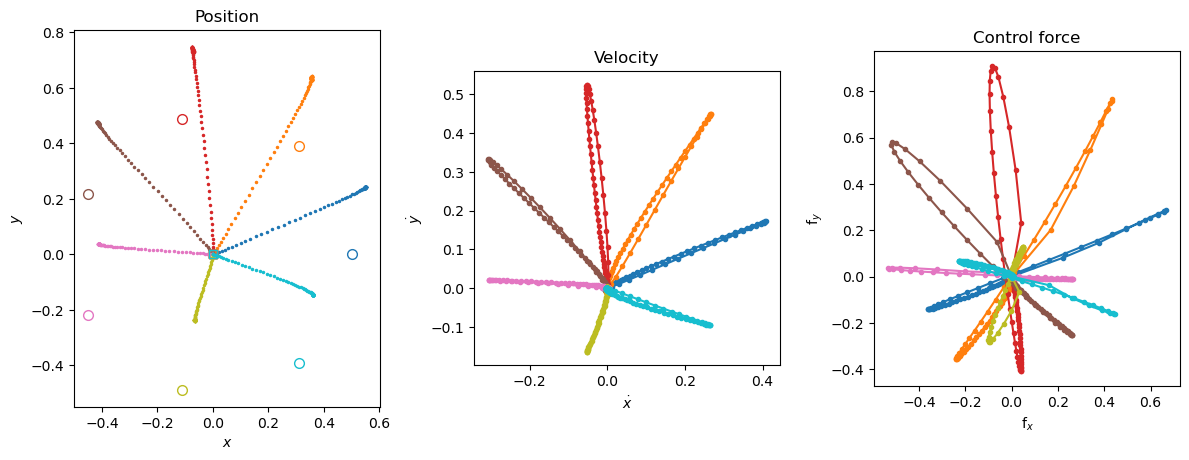

In [22]:
_ = plot_reach_trajectories(
    task.eval(model_clamp_pre, key=key_eval),
    trial_specs=task.validation_trials
)

And after:

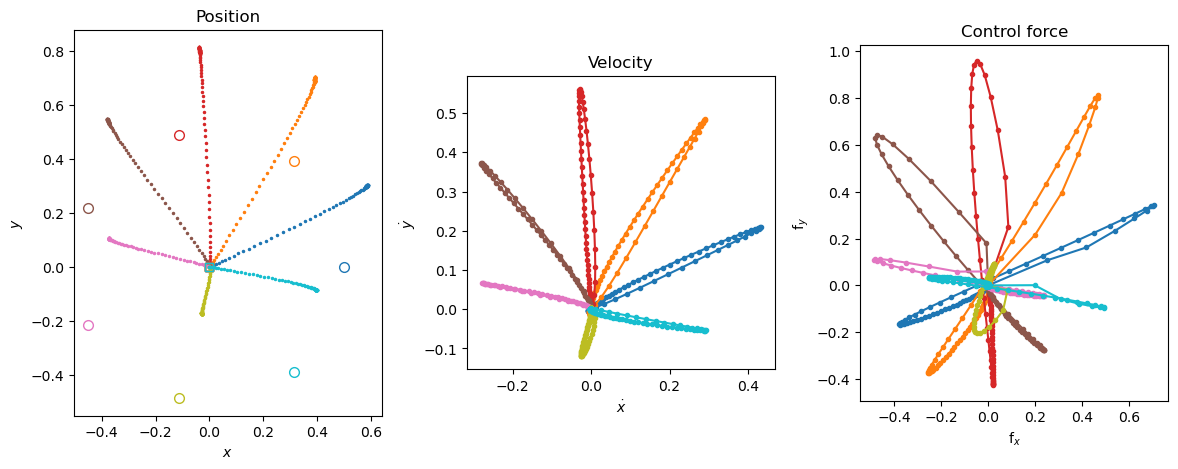

In [23]:
_ = plot_reach_trajectories(
    task.eval(model_clamp_post, key=key_eval),
    trial_specs=task.validation_trials
)

The effect of the perturbation is similar in both cases. The difference is not obvious. However, if you compare the axes limits it is clear that the effect of the perturbation is a bit larger when the perturbation is added after the forward pass of the network. 

!!! Warning ""
    Because we used `add_intervenor` to add the intervention directly to the model, it will always be applied with the constant parameters we chose. The model itself has no knowledge of trials, or that parameters might vary between trials. 
    
    Likewise, while the outermost level of the model may be an `Iterator` that has knowledge of model iterations over time, it 1) is not a staged model, and 2) receives entire trial-length trajectories of task parameters from an instance of `AbstractTask`. Thus `Iterator` is not the appropriate place to insert a time-varying intervention.

## Time-varying interventions

Here's an example of an intervention that is only applied at one time step in each trial. In this case we'll need to use `schedule_intervenor` to set an intervention schedule.

We'll add an impulse perturbation to one of the sensory feedback variables, 80% of the way through the reaching trials. At this point, the point mass has already slowed down at the goal position.

In particular, we'll add `10.0` to the value of the feedback variable that gives information to the neural network about the $x$ position of the point mass. From the network's perspective, it will look like the point mass has suddenly jumped a very large distance to the right of the target, for a single time step. (It will probably react immediately to this insult.)

First, we construct the parameters that the intervenor will need.

In [24]:
import jax.numpy as jnp

impulse_amp = 10.0
impulse_dim = 0  # 0=x, 1=y
impulse_var = 0  # 0=position, 1=velocity

# Get the index of the time step 80% of the way through the trials
t_impulse = int(model.n_steps * 0.8)

# The x and y variables are stored in the same array. We only perturb x,
# so make a mask that's 1 at x and 0 at y.
# (This will still work if we switch impulse_var to 1 (that is, perturb the velocity)
#  because the velocity array has the same x/y shape as the position array.)
array_mask = jnp.zeros((2,)).at[impulse_dim].set(1)

# Make a mask that's 1 at the time step at which the impulse will be applied, and 0 elsewhere
trial_mask = jnp.zeros((model.n_steps - 1,), bool).at[t_impulse].set(True)

Now, schedule the intervenor `ConstantInput`. This intervenor does elementwise addition to a PyTree of state arrays, where `arrays` gives the arrays to add to those in the state—here, we're just adding to a single state array—and `scale` gives a factor by which to multiple `arrays` before adding it.

We'll add this intervenor to `model.step.channels.models`, which contains the only `Channel` object in this model that supplies feedback information to the neural network. `Channel` is a model with two stages:

In [29]:
from feedbax import pprint_model_spec

pprint_model_spec(model.step.channels.models)

update_queue: wrapped: Channel._update_queue
add_noise: wrapped: Channel._add_noise


We want to perturb the channel's output—that is `state.output`, from the perspective of `Channel`. Therefore we'll add the intervenor to the stage `'add_noise'`, since `'update_queue'` pulls a sample out of the feedback queue and overwrites `state.output` with it, which would nullify our intervention if we were to apply it before `'update_queue'`.

In [30]:
from feedbax.intervene import ConstantInput, schedule_intervenor, TimeSeriesParam

task_fb_impulse, model_fb_impulse = schedule_intervenor(
    task, model,
    intervenor=ConstantInput.with_params(
            scale=impulse_amp,
            arrays=array_mask,
            active=TimeSeriesParam(trial_mask),
            # Note that `out_where` is not a scheduled, but a fixed parameter.
            # This is how we choose to perturb the position array, in particular.
            out_where=lambda state: state.output[impulse_var],
        ),
    where=lambda model: model.step.channels.models,
    stage_name='add_noise',
    default_active=False
)

Note that we wrap `trial_mask` as a `TimeSeriesParam` so that the task knows to provide this parameter as-is, rather than broadcasting it to a trajectory like it will normally do. We assign this parameter to `active`, which is a parameter that all intervenors have, that determines whether the intervention is active at the moment. In this case, we only make the intervention active on a single time step.

How does this perturbation affect the model's behaviour?

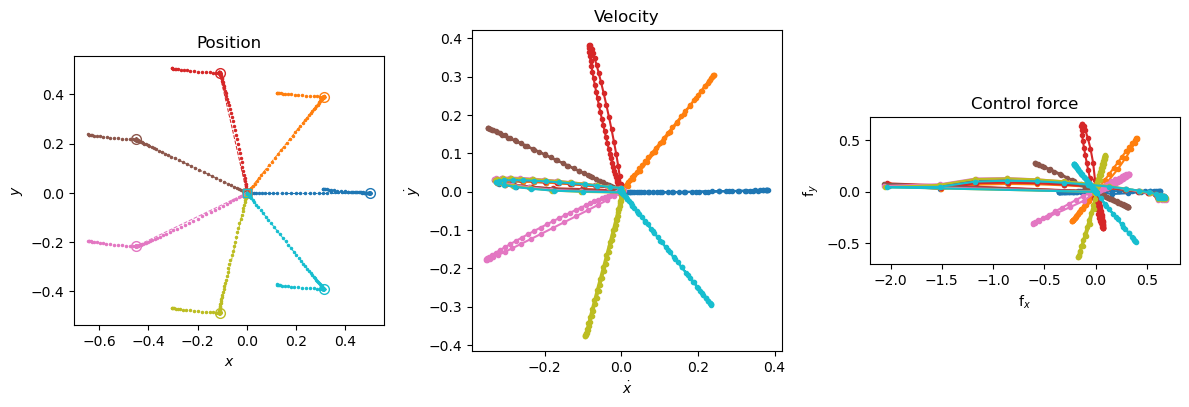

In [32]:
_ = plot_reach_trajectories(
    task_fb_impulse.eval(model_fb_impulse, key=key_eval),
    trial_specs=task.validation_trials,
    straight_guides=True,  # Show dashed lines for "ideal" straight reaches
)

As soon as the network is informed that the point mass has "moved" very far to the right, it pushes back strongly to the left. The point mass moves to the left. In the time steps that follow, feedback is normal, so the network starts to react to the leftward movement by starting to reverse course back towards the goal. The trial ends before it gets back.

## Writing a custom intervenor

Many interventions will have the same general form. For example, `ConstantInput` (constant array) and `AddNoise` (function).

Intervenors are subclasses of [`AbstractIntervenor`][feedbax.intervene.AbstractIntervenor]. Each type of intervenor is associated with a type of parameter PyTree, which is a subclass of [`AbstractIntervenorInput`][feedbax.intervene.AbstractIntervenorInput].

For example, [`CurlField`][feedbax.intervene.CurlField] is associated with [`CurlFieldParams`][feedbax.intervene.CurlFieldParams]. Here's how they're defined.

In [33]:
from collections.abc import Callable
from typing import Optional

from jaxtyping import Array, ArrayLike, PRNGKeyArray

from feedbax.intervene import AbstractIntervenor, AbstractIntervenorInput
from feedbax.mechanics import MechanicsState


class CurlFieldParams(AbstractIntervenorInput):
    """Parameters for a curl force field."""
    amplitude: float = 0.
    active: bool = True


class CurlField(AbstractIntervenor[MechanicsState, CurlFieldParams]):
    """Apply a curl force field to a mechanical effector."""

    params: CurlFieldParams = CurlFieldParams()
    in_where: Callable[[MechanicsState], Array] = lambda state: state.effector.vel
    out_where: Callable[[MechanicsState], Array] = lambda state: state.effector.force
    operation: Callable[[ArrayLike, ArrayLike], ArrayLike] = lambda x, y: x + y
    label: str = "CurlField"

    def transform(
        self,
        params: CurlFieldParams,
        substate_in: Array,
        *,
        key: Optional[PRNGKeyArray] = None
    ) -> Array:
        """Transform velocity into curl force."""
        scale = params.amplitude * jnp.array([-1, 1])
        return scale * substate_in[..., ::-1]

Defining a subclass of `AbstractIntervenorInput` is straightforward. It must include a field `active: bool`, which determines if the intervention is currently active. The other fields are the parameters of the intervenor that we might want to vary over time or across trials. In the case of a curl force field, that's the amplitude of the field—where positive and negative amplitudes correspond to counterclockwise and clockwise fields.

The subclass of `AbstractIntervenor` must define all of the fields that can be seen in `CurlField`. In particular:

- `params` is the static set of parameters associated with the intervenor. 
    - If the intervenor is added to a model using `add_intervenor`, these are the constant parameters of the intervention. 
    - If the intervenor is scheduled with a task using `schedule_intervenor`, they are the default parameters that will be combined with the trial-by-trial parameters provided by the task.
- `in_where` and `out_where` are the functions that select the intervenor's input and output, from the state of the model that the intervenor belongs to. 
    - `CurlField` is an intervenor that's added to a [`Mechanics`][feedbax.mechanics.Mechanics] model, so `in_where` and `out_where` will be passed an instance of [`MechanicsState`][feedbax.mechanics.MechanicsState]. 
    - For the case of a `CurlField` applied to an effector, the input is the velocity of the effector, and the output is the (linear) force applied to the effector.
- `operation` is the function that is used to update the model's state (at `out_where`) with the output of the intervenor. 
    - For example, `CurlField` outputs forces on the effector, but we generally want these to add onto any forces already applied to the effector, not to replace them completely—so the function is addition `lambda x, y: x + y`. 
    - Here, `x` is the original substate and `y` is the intervenor's output, so if we wanted to replace the original substate entirely, we'd use `lambda x, y: y`.
- `label` is a unique label associated with the intervenor, among all the intervenors that have been added to a model or task. Normally you don't set this yourself. It is adjusted by `schedule_intervenor` to make sure that intervention parameters are associated with the right intervenor.

All of these fields can be changed at the time of construction. For example, we might need to change `in_where` or `out_where` if we are using an intervenor to transform between parts of the state that appear in unusual places in the state PyTree.

Finally, the state operation performed by the intervention is defined by the `transform` method. This method is passed the following arguments:

- `params`, which merges any trial-by-trial parameters with the defaults in the `params` field described above;
- `substate_in`, which is the part of the model state selected by `in_where`. In the case of `CurlField`, this is (by default) the array containing the effector velocities.


!!! Note "Typing of intervenors"
    `AbstractIntervenor` is a [`Generic`] of type variables bound to `AbstractState` and to `AbstractIntervenorInput`. This is why `CurlField` inherits from `AbstractIntervenor[MechanicsState, CurlFieldParams]`. When we type a variable as `CurlField` elsewhere, we'll be able to infer whether other variables that provide model state (`MechanicsState`?) and parameter PyTrees (`CurlFieldParams`?) are compatible with this type of intervention.


!!! Note "Intervenors where `in_where == out_where`"

    For many kinds of interventions, the input and the output substates are identical. For example, when adding noise to a state, the input is the substate to which to add noise, and the output is the noise to be added to the same substate.
    
    For now, this must be explicitly specified.